In [2]:
import pandas as pd

jobs_df = pd.read_csv('data/LinkedInJobs_MLDataset.csv')
jobs_df.head()

,Co_Nm,Co_Pg_Lstd,Emp_Cnt,Flw_Cnt,Job_Ttl,Job_Desc,Is_Supvsr,max_sal,med_sal,min_sal,...,st_code,is_remote,views,app_typ,app_is_off,xp_lvl,domain,has_post_domain,is_sponsored,base_comp
0,HearingLife,True,1171,11417,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,False,5250.00,5250.00,5250.00,...,SC,0,9,OffsiteApply,True,Entry level,careers-demant.icims.com,True,0,1
1,"Metalcraft of Mayville, Inc.",True,300,2923,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,False,0.00,0.00,0.00,...,WI,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
2,"U.S. Tsubaki Power Transmission, LLC",True,314,8487,"Manager, Engineering",The TSUBAKI name is synonymous with excellence...,True,0.00,0.00,0.00,...,AL,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
3,Episcopal Communities & Services,True,36,305,Cook,descriptionTitle\n\n Looking for a great oppor...,False,22.27,22.27,22.27,...,CA,0,1,OffsiteApply,True,Entry level,jobs.apploi.com,True,0,1
4,"iHerb, LLC",True,1227,51933,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",False,275834.00,240895.00,205956.00,...,XF,1,0,OffsiteApply,True,Mid-Senior level,careers.iherb.com,True,0,1


In [3]:
import spacy
import re
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
jobs_df['Job_Desc'] = jobs_df['Job_Desc'].astype('str')
descriptions = [re.sub(r'[\d?,.;:!/-]', '', x).strip().lower() for x in jobs_df['Job_Desc'].values]
documents = list(tqdm(nlp.pipe(descriptions, n_process=12), total=len(descriptions)))

100%|██████████| 33246/33246 [04:28<00:00, 123.74it/s]


In [71]:
from gensim.corpora import Dictionary

stop_words = list("\n firm type diploma closing date send level space job offer company firms oct connect jobs \
                  fcfa price spaces articles tax year cv job interview motivation letter advice questions mail \
                  work answers recruiters expired internship company send do activity sector have profile file \
                  company years address direction cv location benefit healthcare knowledge pet week gender status \
                  disability orientation color experience team include require skill ™ opportunity ability need ensure \
                  use care base pay position include requirement responsibility degree qualification member qualification \
                  apply application office candidate day make provide policy life applicant value part practice hour range \
                  area assign join relate change follow standard salary prefer function career regard field take age identity \
                  problem project service religion receive state tool description".split())

texts = [[word.lemma_ for word in doc if (word.pos_ in ['NOUN', 'VERB']) and (word.lemma_ not in stop_words)] for doc in tqdm(documents)]
dictionary = Dictionary(tqdm(texts))
corpus = [dictionary.doc2bow(text) for text in tqdm(texts)]

100%|██████████| 33246/33246 [00:02<00:00, 14353.40it/s]


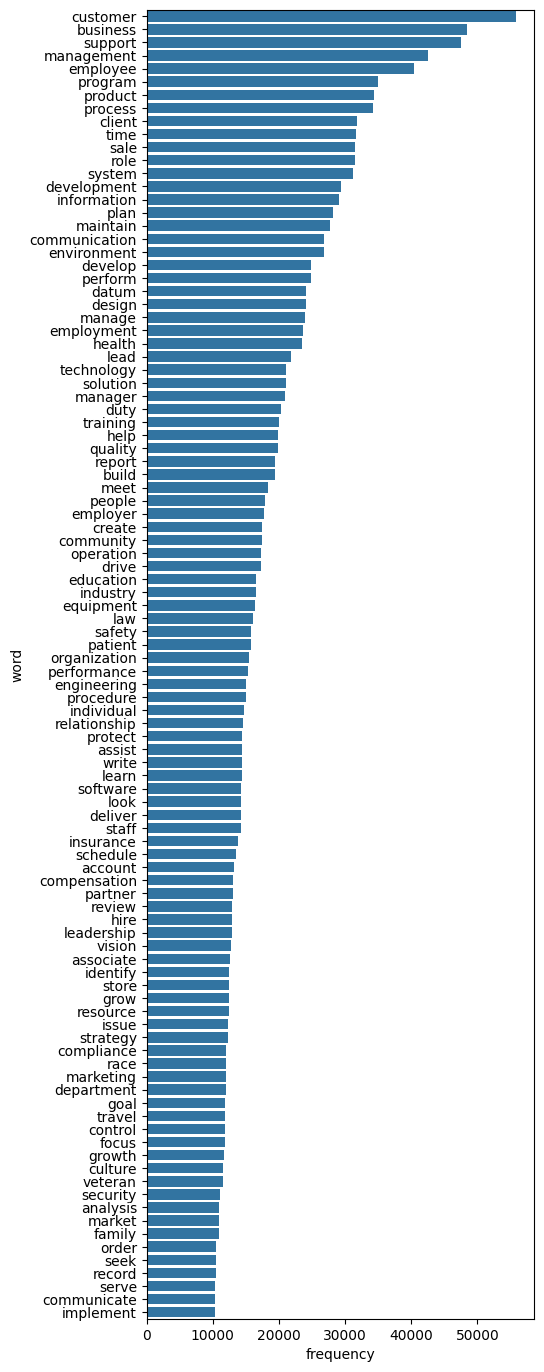

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bag_of_words_df = pd.DataFrame.from_records([{'word': dictionary[id], 'frequency': freq} for doc in corpus for id, freq in doc])
bag_of_words_df = bag_of_words_df.groupby('word').sum().sort_values('frequency', ascending=False)
bag_of_words_df.reset_index(inplace=True)

plt.figure(figsize=(5, 17))
sns.barplot(x='frequency', y='word', data=bag_of_words_df.head(100))
plt.show()

100%|██████████| 12/12 [08:20<00:00, 41.70s/it]


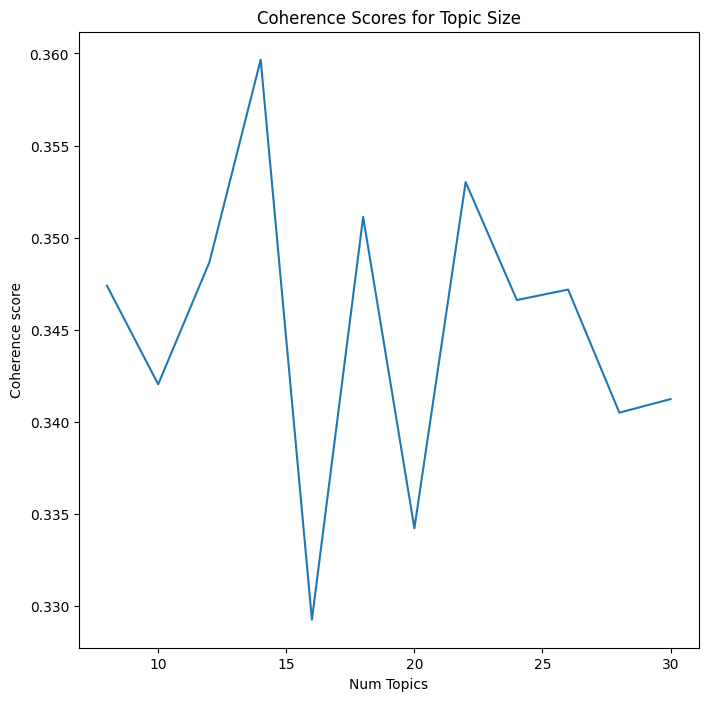

In [76]:
import matplotlib.pyplot as plt

from gensim.models import LdaMulticore, CoherenceModel

def compute_coherence_values(corpus, dictionary, texts, end, start=2, step=3):
   
    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(range(start, end, step)):
    
        # Build LDA model
        lda_model = LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics, 
                                random_state=123,
                                chunksize=100,
                                per_word_topics=True)
        model_list.append(lda_model)
        
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values
    
start=8; end=32; step=2
#Prior investigation has narrowed down the search to between 8 and 15 topics
model_list, coherence_values = compute_coherence_values(corpus, dictionary, texts, start=start, end=end, step=step)

# Show graph
x = range(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Coherence Scores for Topic Size')
plt.show()

In [75]:
import pyLDAvis
import pyLDAvis.gensim_models
import numpy as np

coherence_values = np.array(coherence_values)
best_model_index = coherence_values.argmax()
best_model = model_list[best_model_index]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.055158  0.019448       1        1  18.468468
8     -0.022544  0.008421       2        1  13.358279
9     -0.085435 -0.002820       3        1  11.158719
2      0.032713 -0.026316       4        1  10.952416
7      0.089131  0.084753       5        1   9.147365
4     -0.013196 -0.034216       6        1   9.003680
3      0.073404  0.014452       7        1   8.594235
6     -0.004105 -0.024586       8        1   8.181323
10     0.057382 -0.102467       9        1   4.844038
1     -0.065856  0.019194      10        1   2.396288
11     0.001743  0.021945      11        1   2.250950
5     -0.008079  0.022192      12        1   1.644238, topic_info=            Term          Freq         Total Category  logprob  loglift
21      business  49737.000000  49737.000000  Default  30.0000  30.0000
174         sale  30372.000000  30372.000000  Default  29.0000  29.0000
143      patient  16630.000000  16630.000000  Default  28.0000  28.0000
757       client  32416.000000  32416.000000  Default  27.0000  27.0000
70     equipment  18124.000000  18124.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
173         role    388.155745  31767.689432  Topic12  -5.5982  -0.2969
386       system    389.383632  32669.675713  Topic12  -5.5951  -0.3217
320       design    363.523482  25158.078397  Topic12  -5.6638  -0.1292
550  information    365.740265  29641.990404  Topic12  -5.6577  -0.2871
220     customer    376.661356  54405.318592  Topic12  -5.6283  -0.8650

[1177 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
13169      1  0.010845      a(an
13169      2  0.010845      a(an
13169      3  0.010845      a(an
13169      4  0.010845      a(an
13169      5  0.921801      a(an
...      ...       ...       ...
23222      5  0.079343  â€œserve
23222      8  0.714085  â€œserve
23222      9  0.026448  â€œserve
23222     11  0.052895  â€œserve
21626      8  0.761629    â€”are

[6504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 10, 3, 8, 5, 4, 7, 11, 2, 12, 6])